In [4]:
import numpy as np
import pymc3 as pm

import pandas as pd
from scipy.special import logit, expit

import matplotlib.pyplot as plt

In [5]:
scores = np.concatenate([np.load(f'../processed_data/D4_all{i}.npy') for i in range(10)])

In [6]:
df = pd.read_csv('../data/41586_2019_917_MOESM4_ESM.csv')

In [7]:
#these are the docking scores:
df['Energy'] = np.array(df['Energy'].str.strip('¶')).astype(float)

#set the "not determined" records to zero inhibition:
df.loc[df['Inhibition (%) at 10uM'].str.contains('ND'), 'Inhibition (%) at 10uM'] = 0


In [8]:
#this simply uses argsort (twice) to find the 1-indexed rank of each score, including
#the ligands used in _in vitro_ validation. Ranks are then normalized by dividing by 
#number of items

normalized_ranks = ( (np.concatenate([scores, df['Energy']]).argsort().argsort()+1) /\
                ((scores.shape[0]+df['Energy'].shape[0]) - 1) )

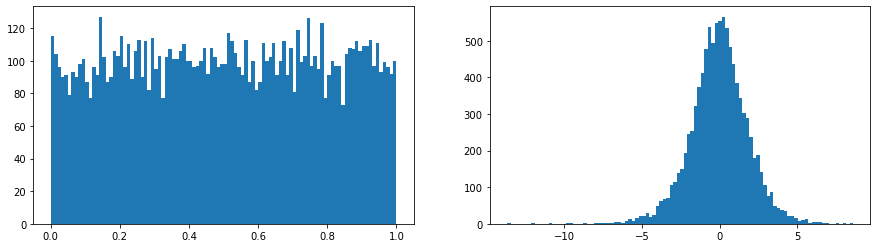

In [9]:
#we can see that the logit(normalized_ranks) are normally distrubuted, 
#which is what you would expect when logit-transforming a uniformly-distributed

fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)

_ = ax[0].hist(np.random.choice(normalized_ranks, 10000), bins=100)
_ = ax[1].hist(logit(np.random.choice(normalized_ranks, 10000)), bins=100)

In [10]:
#this holds the ranks of the in vitro tested molecules:
ranks = normalized_ranks[-df['Energy'].shape[0]:]
hits = df['Inhibition (%) at 10uM'].values.astype(float)>50


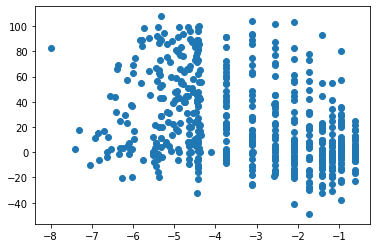

In [11]:
#observe that this resembles Lyu et al, except the points at the bottom of the 
#curve are bunched a bit closer. This more accurately represents
#where the tested range sits in comparison to the rest of the distribution.


plt.scatter(np.log10(ranks), df['Inhibition (%) at 10uM'].values.astype(float))

In [12]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

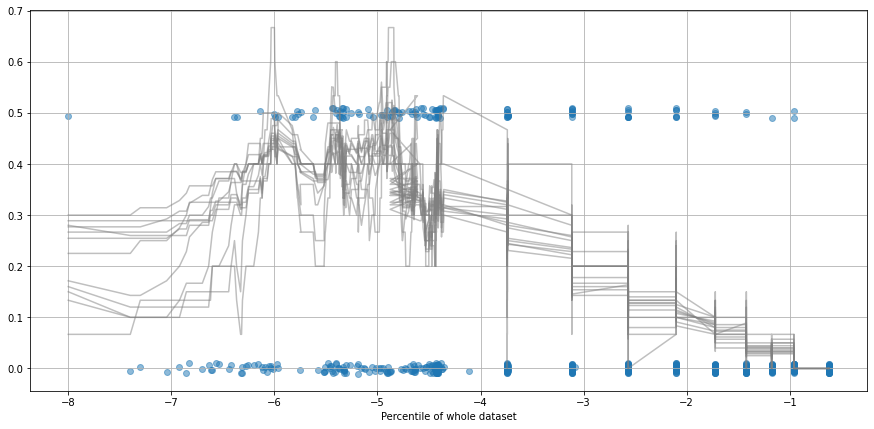

In [13]:
plt.figure(figsize=(15,7))
for n in [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]:
    
    #plt.plot(np.array(ranks[np.argsort(ranks)][:-n+1])* 100, running_mean(hits[np.argsort(ranks)], n), c='grey', alpha=0.5)
    plt.plot(np.log10(np.array(ranks)[:-n+1]), running_mean(hits[np.argsort(ranks)], n), c='grey', alpha=0.5)

    
#plt.xscale('log')
plt.xlabel('Percentile of whole dataset')
plt.grid()

#plt.axvline(0.15)

plt.scatter(np.log10(ranks), 
            (df['Inhibition (%) at 10uM'].values.astype(float)>50) / 2 + \
            np.random.uniform(-0.01, 0.01, len(ranks)),
           alpha=0.5)

In [14]:
x = []
y = []
detail = []

plt.figure(figsize=(15,7))
for n in [20, 25, 30, 35, 40, 45, 50, 55, 60,]:
    
    #plt.plot(np.array(ranks[np.argsort(ranks)][:-n+1])* 100, running_mean(hits[np.argsort(ranks)], n), c='grey', alpha=0.5)
    x_ = 100*np.array(ranks)[np.argsort(ranks)][:-n+1]
    y_ = running_mean(hits[np.argsort(ranks)], n)
    z_ = np.ones(len(y_))*n
    
    x+=list(x_)
    y+=list(y_)
    detail+=list(z_)



<Figure size 1080x504 with 0 Axes>

In [15]:
df_ = pd.DataFrame({'x':x, 'y':y, 'detail':detail})

In [16]:
import altair as alt

ch = alt.Chart(df_).mark_line(opacity=0.4).encode(
    x=alt.X('x:Q',scale=alt.Scale(type='log'), title='Percentile docking score'),
    y=alt.Y('y:Q', title='In vitro hit rate'),
    detail='detail'
)

ch.properties(width=800, height=400)

alt.Chart(...)

In [333]:
from pygam import LinearGAM, s, f, GAM

#gam = LinearGAM(s(0, n_splines=8,)).fit(np.log10(ranks)[:,None],  hits.astype(int))
gam = GAM(s(0, n_splines=8,), 
          distribution='binomial',
          link='logit',
          #distribution='normal',
          #link='log',
         ).fit(np.log10(ranks)[:,None],  
               hits.astype(int))


In [384]:
max(np.log10(ranks))

-0.6182174382580197

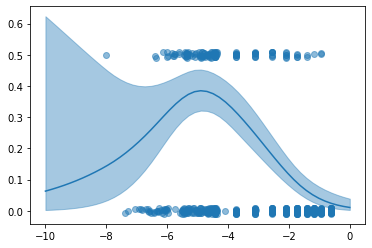

In [382]:
x = np.linspace(-10, 0)[:,None]
plt.plot(x, gam.predict(x))
plt.scatter(np.log10(ranks), 
            (df['Inhibition (%) at 10uM'].values.astype(float)>50) / 2 + \
            np.random.uniform(-0.01, 0.01, len(ranks)),
           alpha=0.5)
plt.fill_between(x.ravel(), *gam.confidence_intervals(x).T, alpha=0.4, color='C0')

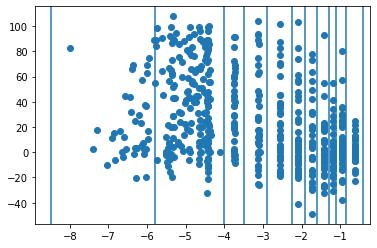

In [335]:
plt.scatter(np.log10(ranks), df['Inhibition (%) at 10uM'].values.astype(float))
bins = [-8.5, -5.8, -4, -3.5, -2.9, -2.25, -1.9, -1.6, -1.3, -1.1, -0.85, -.4]
for b in bins:
    plt.axvline(b)

In [336]:

idx = np.digitize(np.log10(ranks), bins)

In [385]:
from statsmodels.stats.proportion import proportion_confint
df_prop = pd.DataFrame(columns=['x', 'y', 'y1', 'y2'])
for i in range(1, idx.max()+1):
    samples = hits[idx==i]
    propci = proportion_confint(samples.sum(), nobs=len(samples), method='jeffreys')
    print(samples.mean(), propci)
    df_prop.loc[i-1] = [100*10**((bins[i-1]+bins[i])/2), samples.mean(), propci[0], propci[1]]

0.20512820512820512 (0.10206193746040886, 0.350086962927313)
0.3879781420765027 (0.3195841780845337, 0.4598842444908555)
0.3157894736842105 (0.1856138501203135, 0.4728433710422403)
0.23684210526315788 (0.12415617766169264, 0.38788297874502586)
0.175 (0.08185393408002506, 0.31317231261408185)
0.15789473684210525 (0.0687035882721138, 0.2968271998403339)
0.1111111111111111 (0.03868714601646236, 0.2428730120234911)
0.05714285714285714 (0.012063652129890362, 0.17091684882105385)
0.027777777777777776 (0.0030136938252919216, 0.12257359234796428)
0.05714285714285714 (0.012063652129890362, 0.17091684882105385)
0.0 (1.3929610979532534e-05, 0.06877653611605908)


In [386]:
base = alt.Chart(df_prop).transform_calculate(

)

# generate the points
points = base.mark_point(
    filled=True,
    size=50,
    color='black'
).encode(
    x=alt.X('x', scale=alt.Scale(type='log')),
    y=alt.Y('y', title='In vitro hit rate'),
)

# generate the error bars
errorbars = base.mark_errorbar().encode(
    x=alt.X("x",scale=alt.Scale(type='log')),
    y=alt.Y('y1:Q',title='In vitro hit rate'),
    y2="y2:Q"
)

In [392]:
x = np.linspace(-8, -.25)[:,None]
df_ = pd.DataFrame({'x':10**x.ravel()*100, 
                   'y':gam.predict(x), 
                  'y1':gam.confidence_intervals(x).T[0],
                 'y2':gam.confidence_intervals(x).T[1]})

ch = alt.Chart(df_).mark_line(opacity=0.4).encode(
    x=alt.X('x:Q', title='Percentile docking score', scale=alt.Scale(type='log')),
    y=alt.Y('y:Q', title='In vitro hit rate'),
)


ci = alt.Chart(df_).mark_area(opacity=0.3).encode(
    x=alt.X('x:Q', scale=alt.Scale(type='log')),
    y=alt.Y('y1:Q',title='In vitro hit rate'),
    y2='y2:Q'
)


In [393]:
points+errorbars+ch+ci

alt.LayerChart(...)

In [399]:
df_prop

,x,y,y1,y2
0,0.000007,0.205128,0.102062,0.350087
1,0.001259,0.387978,0.319584,0.459884
2,0.017783,0.315789,0.185614,0.472843
3,0.063096,0.236842,0.124156,0.387883
4,0.266073,0.175000,0.081854,0.313172
5,0.841395,0.157895,0.068704,0.296827
6,1.778279,0.111111,0.038687,0.242873
7,3.548134,0.057143,0.012064,0.170917
8,6.309573,0.027778,0.003014,0.122574
9,10.592537,0.057143,0.012064,0.170917


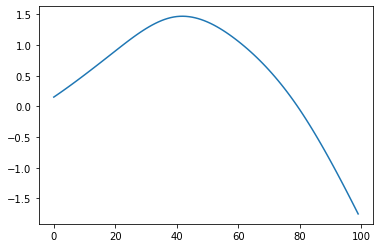

In [389]:
plt.figure()
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.plot(gam.partial_dependence(term=i))